# Video game Random Forest - resample - EU from NA and JP
This notebook uses a Random Forest ML model to predict EU Sales based on Platform, Genre, NA_Sales, and JP_Sales. The notebook sets the threshold for EU_Sales to some value independent of the median value of EU_Sales and investigates oversampling, undersampling, and combination sampling to balance the yes/no values for EU_Sales. 

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

import psycopg2
from config import config

%matplotlib inline
import matplotlib.pyplot as plt

## Read in data and remove unnecessary columns

In [2]:
#Define Function to Retrieve Data From Heroku
def get_Data():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
         # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        sql = "SELECT gm.rank, gm.na_sales, gm.eu_sales, gm.jp_sales, " \
                "p.platform, " \
                "g.genre " \
                "FROM game gm " \
                "INNER JOIN platform p " \
                "ON gm.platform_id=p.id " \
                "INNER JOIN genre g " \
                "ON gm.genre_id=g.id"
            
        #print('PostgreSQL database query: ' sql)
        query = pd.read_sql_query(sql, conn)
        
        df = pd.DataFrame(query)
        return df
    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [3]:
#Query Heroku For Data and create DataFrame
df = get_Data()
df

Connecting to the PostgreSQL database...
Database connection closed.


,rank,na_sales,eu_sales,jp_sales,platform,genre
0,6086,0.00,0.00,0.29,PS3,Sports
1,6819,0.06,0.13,0.00,PS2,Action
2,8108,0.05,0.10,0.00,PS2,Racing
3,7038,0.13,0.09,0.00,GBA,Shooter
4,14545,0.02,0.01,0.00,3DS,Adventure
...,...,...,...,...,...,...
9795,3059,0.26,0.01,0.13,PS3,Puzzle
9796,1469,0.79,0.42,0.00,Wii,Action
9797,4063,0.00,0.47,0.00,DS,Action
9798,3406,0.24,0.28,0.00,Wii,Fighting


In [4]:
# Reorder and Rename Columns for Machine Learning Model
vg_sales_df = df.reindex(columns= ['rank', 'platform', 'genre', 'na_sales', 'eu_sales', 'jp_sales'])
#vg_sales_df.set_index("Rank", inplace=True)
vg_sales_df.drop(['rank'], axis=1, inplace=True)
vg_sales_df.columns = ['Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales']
vg_sales_df

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales
0,PS3,Sports,0.00,0.00,0.29
1,PS2,Action,0.06,0.13,0.00
2,PS2,Racing,0.05,0.10,0.00
3,GBA,Shooter,0.13,0.09,0.00
4,3DS,Adventure,0.02,0.01,0.00
...,...,...,...,...,...
9795,PS3,Puzzle,0.26,0.01,0.13
9796,Wii,Action,0.79,0.42,0.00
9797,DS,Action,0.00,0.47,0.00
9798,Wii,Fighting,0.24,0.28,0.00


In [5]:
print(vg_sales_df.dtypes)

Platform     object
Genre        object
NA_Sales    float64
EU_Sales    float64
JP_Sales    float64
dtype: object


In [6]:
# Get unique Platform values
vg_sales_df["Platform"].unique()

array(['PS3', 'PS2', 'GBA', '3DS', 'PS', 'PSP', 'DS', 'Wii', 'PC', 'X360',
       'GC', 'PSV', 'N64', 'XB', 'GB', 'NES', 'XOne', 'SAT', 'WiiU',
       'SNES', '2600', 'PS4', 'GEN', 'DC', '3DO', 'SCD', 'WS', 'PCFX',
       'NG'], dtype=object)

In [7]:
# Make sure there are no null values
vg_sales_df["Platform"].isnull().sum()

0

In [8]:
# Get unique Genre values
vg_sales_df["Genre"].unique()

array(['Sports', 'Action', 'Racing', 'Shooter', 'Adventure',
       'Role-Playing', 'Fighting', 'Simulation', 'Misc', 'Platform',
       'Puzzle', 'Strategy'], dtype=object)

In [9]:
# Make sure sales columns do not have null values
print(f"NA_Sales has {vg_sales_df['NA_Sales'].isnull().sum()} null values.")
print(f"EU_Sales has {vg_sales_df['EU_Sales'].isnull().sum()} null values.")
print(f"JP_Sales has {vg_sales_df['JP_Sales'].isnull().sum()} null values.")

NA_Sales has 0 null values.
EU_Sales has 0 null values.
JP_Sales has 0 null values.


## Histogram of Sales Data

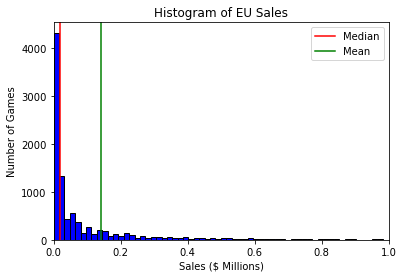

The median sales for EU is $0.02 Million


In [10]:
# Create Histogram to view NA Sales distribution
plt.hist(vg_sales_df['EU_Sales'], color = 'blue', edgecolor = 'black',
         bins = 800)
plt.title('Histogram of EU Sales')
plt.xlabel('Sales ($ Millions)')
plt.ylabel('Number of Games')
plt.xlim(left=0, right=1)
plt.axvline(vg_sales_df['EU_Sales'].median(),label="Median",color='red')
plt.axvline(vg_sales_df['EU_Sales'].mean(),label="Mean",color='green')
plt.legend()
plt.show()

print(f"The median sales for EU is ${round(vg_sales_df['EU_Sales'].median(),3)} Million")

## Categorize Other_Sales Column

In [11]:
# Copy vg_sales_df
categorize_eu_sales = vg_sales_df.filter(["EU_Sales"], axis=1)
categorize_eu_sales

,EU_Sales
0,0.00
1,0.13
2,0.10
3,0.09
4,0.01
...,...
9795,0.01
9796,0.42
9797,0.47
9798,0.28


## Set Threshold Sales Number

In [12]:
# Set threshold sales number
# na_sales_threshold = round(sales_data_nrm['NA_Sales'].median(),3)
eu_sales_threshold = vg_sales_df.filter(["EU_Sales"], axis=1).quantile(q=0.75)[0]

In [13]:
# Reassign NA_sales value
for index,row in categorize_eu_sales.iterrows():
    
    # NA Sales
    if row.EU_Sales > eu_sales_threshold:
        categorize_eu_sales.loc[index] = 1
    else:
        categorize_eu_sales.loc[index] = 0

eu_sales_col_name = "EU_Sales_gt_" + str(eu_sales_threshold)
categorize_eu_sales.\
    rename(columns={"EU_Sales": eu_sales_col_name}, inplace=True)

categorize_eu_sales.head()

,EU_Sales_gt_0.11
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


In [14]:
# Write categorized df to csv file
# output_file_str = "EU_Sales_nrm_thresh_" + \
#     str(eu_sales_threshold).split(".")[0] + "p" + str(eu_sales_threshold).split(".")[1] + ".csv"
# categorize_eu_sales.to_csv('resources/' + output_file_str)

## Separate Sales Data for NA and JP

In [15]:
sales_data = vg_sales_df.filter(["NA_Sales", "JP_Sales"], axis=1)
sales_data.head()

,NA_Sales,JP_Sales
0,0.00,0.29
1,0.06,0.00
2,0.05,0.00
3,0.13,0.00
4,0.02,0.00


In [16]:
# Create platform df
platform_df = vg_sales_df.filter(["Platform"], axis=1)
platform_df.head()

,Platform
0,PS3
1,PS2
2,PS2
3,GBA
4,3DS


## Encode Platform data

In [17]:
# Encode platform df
platform_encoded_df = pd.get_dummies(platform_df)
platform_encoded_df.head()

,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_N64,...,Platform_PSV,Platform_SAT,Platform_SCD,Platform_SNES,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Get shape of platform_encoded_df
platform_encoded_df.shape

(9800, 29)

In [19]:
# Write encoded platform data to CSV
# platform_encoded_df.to_csv('resources/encoded_platform.csv')

## Encode Genre data

In [20]:
# Create genre df
genre_df = vg_sales_df.filter(["Genre"], axis=1)
genre_df.head()

,Genre
0,Sports
1,Action
2,Racing
3,Shooter
4,Adventure


In [21]:
# Encode genre df
genre_encoded_df = pd.get_dummies(genre_df)
genre_encoded_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
# Get shape of genre_encoded_df
genre_encoded_df.shape

(9800, 12)

In [23]:
# Write encoded genre data to CSV
# genre_encoded_df.to_csv('resources/encoded_genre.csv')

## Combine dataframes for analysis

In [24]:
# Combine dataframes to create sales_df_encoded
sales_df_encoded = categorize_eu_sales.join(sales_data, how='outer').\
    join(platform_encoded_df, how='outer').join(genre_encoded_df, how='outer')
sales_df_encoded.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0.0,0.00,0.29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,0.06,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.05,0.00,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.13,0.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.0,0.02,0.00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Create smaller df of 100 rows selected randomly from larger dataset
sales_reduced = sales_df_encoded.sample(n=9800)
sales_reduced.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
3757,0.0,0.01,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
318,0.0,0.00,0.00,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2799,0.0,0.06,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9121,0.0,0.08,0.04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2307,0.0,0.00,0.06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Drop the index
sales_reduced_no_idx = sales_reduced.reset_index(drop=True)
sales_reduced_no_idx.head()

,EU_Sales_gt_0.11,NA_Sales,JP_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0.0,0.01,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.00,0.00,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.0,0.06,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0.08,0.04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.00,0.06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Perform ML with Logistic Regression

In [27]:
# Count True/False NA_Sales numbers
sales_reduced_no_idx[eu_sales_col_name].value_counts()

0.0    7426
1.0    2374
Name: EU_Sales_gt_0.11, dtype: int64

In [28]:
# Set X and y data
y = sales_reduced_no_idx[eu_sales_col_name]
X = sales_reduced_no_idx.drop(columns=eu_sales_col_name)

In [29]:
# Split data into training and testing data
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
# X_train.shape
Counter(y_train)

Counter({0.0: 5570, 1.0: 1780})

In [30]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# # Fit the Standard scaler with the training data
X_scaler = scaler.fit(X_train)

# # Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Oversample data

Random Oversampling

In [31]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

Counter(y_resampled)

Counter({0.0: 5570, 1.0: 5570})

In [32]:
# Create a RF model
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators=128, random_state=1)

In [33]:
# Train the model
# classifier.fit(X_train, y_train)
classifier_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=128, random_state=1)

In [34]:
y_pred = classifier_rf.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,1.0,1.0
8,0.0,0.0
9,1.0,0.0


In [35]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8628571428571429


In [36]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8299255123069778

In [37]:
# # Print confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,1659,197
Actual > threshold,139,455


In [38]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91      1856
         1.0       0.70      0.77      0.73       594

    accuracy                           0.86      2450
   macro avg       0.81      0.83      0.82      2450
weighted avg       0.87      0.86      0.86      2450



In [39]:
print('Train Score: ', classifier_rf.score(X_resampled, y_resampled))  
print('Test Score: ', classifier_rf.score(X_test, y_test)) 

Train Score:  0.9675942549371633
Test Score:  0.283265306122449


In [40]:
print('Train Score: ', classifier_rf.score(X_resampled, y_resampled))  
print('Test Score: ', classifier_rf.score(X_test_scaled, y_test)) 

Train Score:  0.9675942549371633
Test Score:  0.8628571428571429


In [41]:
# Look at feature importance
# importances = classifier_rf.feature_importances_
# importances

In [42]:
# Sort the features by their importance.
# sorted(zip(classifier_rf.feature_importances_, X.columns), reverse=True)

Investigate Probabilities

In [43]:
# Find probabilities
probs_0 = classifier_rf.predict_proba(X_test_scaled)[:,0]
probs_1 = classifier_rf.predict_proba(X_test_scaled)[:,1]

# Create dataframe with predictions and probabilities
pred_df = pd.DataFrame({
    "Validation":y_test,
    "Prediction":y_pred,
    "0_Probability":probs_0,
    "1_Probability":probs_1
})

# Create dataframe for 0 class, then create histograms to display probabilities
probs_0_df = pred_df.loc[pred_df["Prediction"] == 0]

# Create dataframe for 1 class, then create histograms to display probabilities
probs_1_df = pred_df.loc[pred_df["Prediction"] == 1]

Plot probability histograms

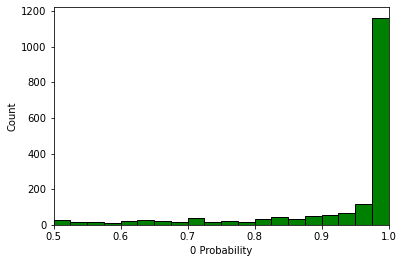

In [44]:
plt.hist(probs_0_df["0_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("0 Probability")
plt.ylabel("Count")
# plt.savefig('RF_0_probability_hist.png')
plt.show()

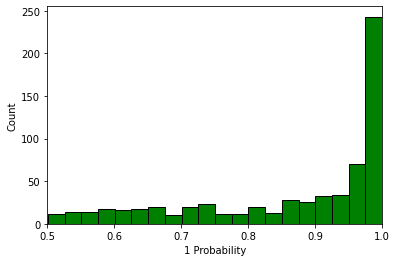

In [45]:
plt.hist(probs_1_df["1_Probability"], color = 'green', edgecolor = 'black',
         bins = 20)
plt.xlim(left=0.5, right=1)
plt.xlabel("1 Probability")
plt.ylabel("Count")
# plt.savefig('RF_1_probability_hist.png')
plt.show()